In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


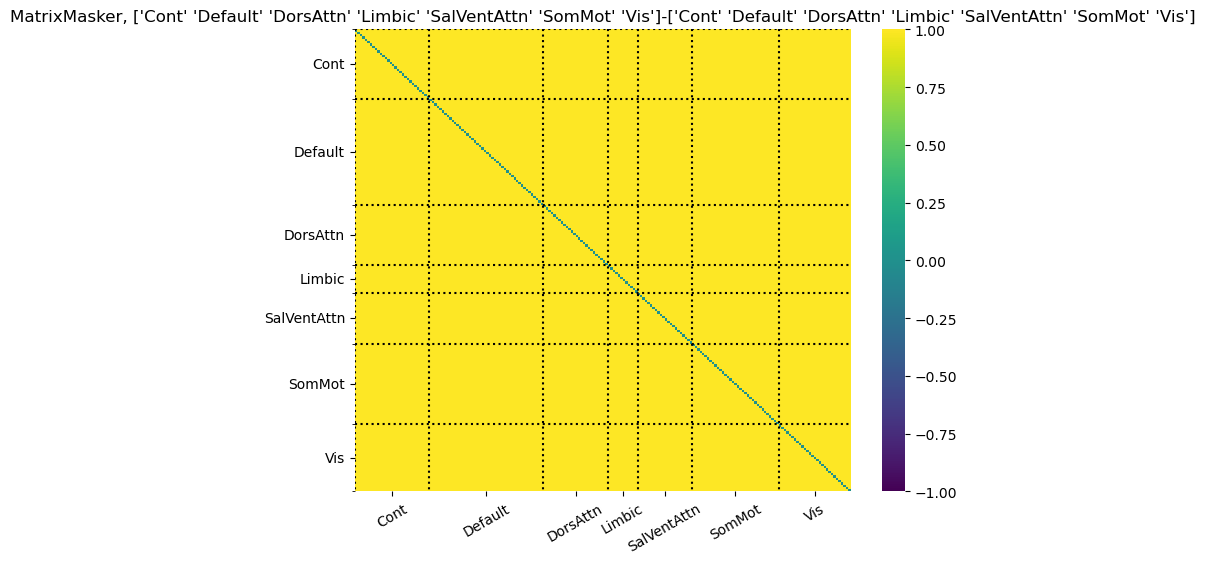

In [3]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

In [4]:
from sklearn.metrics import f1_score
def score_func(y_test, y_pred):
    f1_scores = []
    for curr_label in np.unique(y_test):
        y_test_ovr = np.where(y_test == curr_label, 1, 0)
        y_pred_ovr = np.where(y_pred == curr_label, 1, 0)
        f1_scores.append(
            f1_score(y_test_ovr, y_pred_ovr)
        ) 
    return f1_scores # No point in yielding

In [5]:
from cogpred.supervised import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from nilearn.connectome import vec_to_sym_matrix
from cogpred.matrices import compute_mat_size

net = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        max_iter=3000,
        random_state=2024,
    )

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)


cats = ("stable", "slow", "steep")
outer_cv = GroupKFold(n_splits=8)

test_scores, cm, patterns = run_cv(clf, matrices, metadata, outer_cv)

masker = clf.named_steps["matrixmasker"]
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
hmat = vec_to_sym_matrix(
    patterns.transpose((0, 2, 1)), diagonal=np.zeros((outer_cv.n_splits, k, n_regions))
)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71       221
           1       0.06      0.36      0.11        14
           2       0.00      0.00      0.00         3

    accuracy                           0.55       238
   macro avg       0.33      0.31      0.27       238
weighted avg       0.86      0.55      0.66       238

              precision    recall  f1-score   support

           0       0.87      0.46      0.60       101
           1       0.18      0.57      0.28        23
           2       0.12      0.12      0.12        16

    accuracy                           0.44       140
   macro avg       0.39      0.38      0.33       140
weighted avg       0.67      0.44      0.49       140

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       103
           1       0.30      0.56      0.39        25
           2       0.19      0.45      0.27        11

    accuracy        

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

              precision    recall  f1-score   support

           0       0.85      0.40      0.55       109
           1       0.26      0.48      0.34        31
           2       0.00      0.00      0.00         0

    accuracy                           0.42       140
   macro avg       0.37      0.30      0.29       140
weighted avg       0.72      0.42      0.50       140

              precision    recall  f1-score   support

           0       0.73      0.54      0.62        87
           1       0.35      0.58      0.44        38
           2       0.21      0.20      0.21        15

    accuracy                           0.51       140
   macro avg       0.43      0.44      0.42       140
weighted avg       0.58      0.51      0.53       140

              precision    recall  f1-score   support

           0       0.74      0.24      0.36       110
           1       0.15      0.50      0.23        26
           2       0.10      0.33      0.15         6

    accuracy        

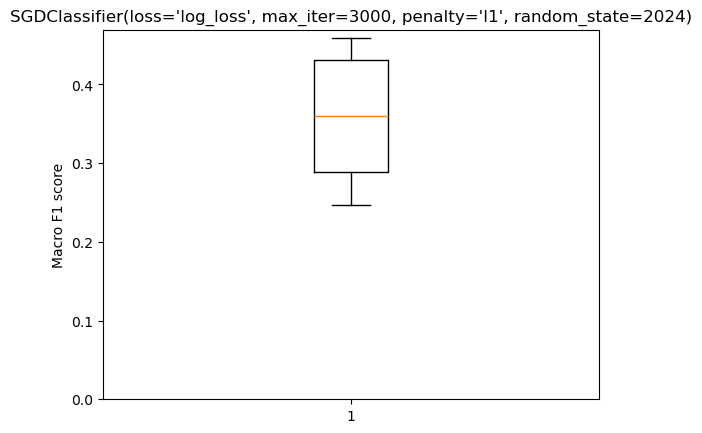

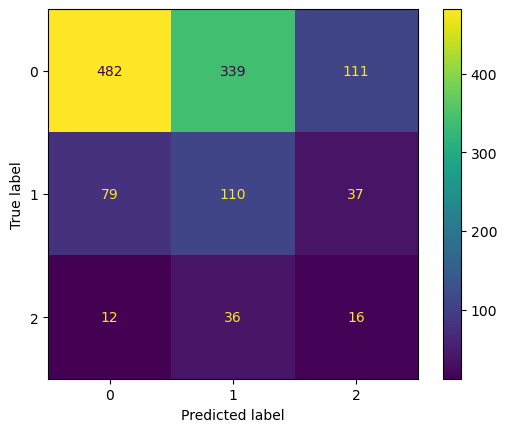

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot(test_scores)
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.ylabel("Macro F1 score")
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

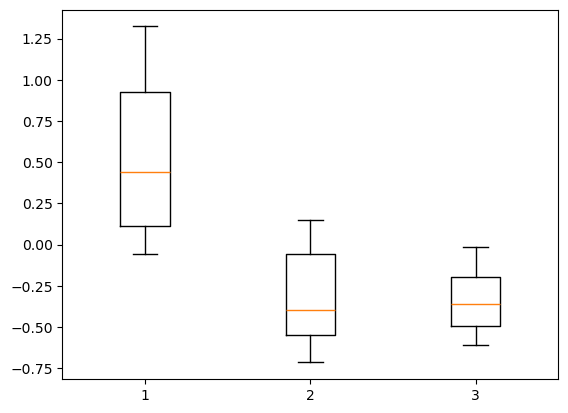

In [7]:
r_stable = hmat[:, 0, ...].mean(axis=(1, 2))
r_slow = hmat[:, 1, ...].mean(axis=(1, 2))
r_steep = hmat[:, 2, ...].mean(axis=(1, 2))
plt.boxplot(
    (
        r_stable,
        r_slow,
        r_steep,
    )
)
plt.show()

In [8]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


/bigdata/jlegrand/cogpred/cogpred/plotting.py:43: RuntimeWarning: invalid value encountered in divide
  cvmap = np.std(hmat[:, i, ...], axis=0) / meanmap
/bigdata/jlegrand/cogpred/cogpred/plotting.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


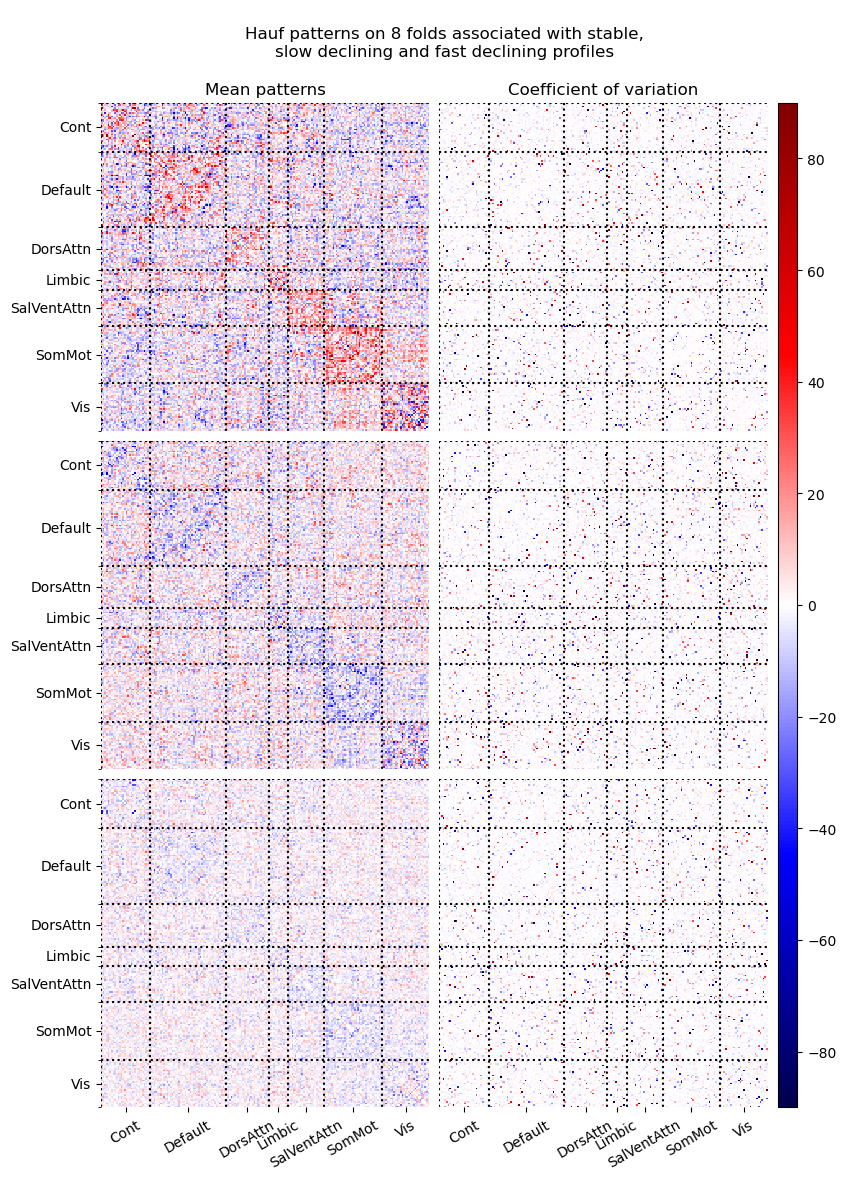

In [9]:
from cogpred.plotting import plot_haufe_pattern

plot_haufe_pattern(hmat, disp_atlas)
plt.show()

# Test significant score

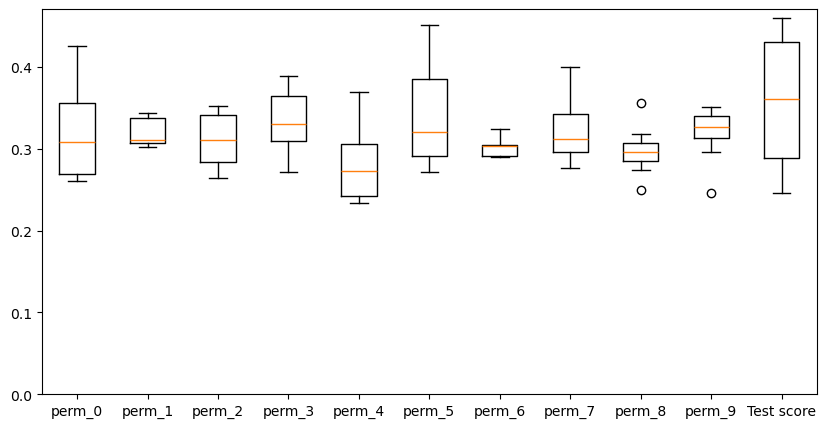

In [10]:
import random

N = 5000
#p = Path("/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default")
p = run_path
perm_res = joblib.load(p / f"{N}_permutations_res.joblib")
permscores = [pr[0] for pr in perm_res]
permweights = [pr[1] for pr in perm_res]

disp_sample = random.sample(permscores, k=10)
disp_sample.append(test_scores)

labels = [f"perm_{i}" for i in range(10)]
labels.append("Test score")

plt.subplots(figsize=(10, 5))
plt.boxplot(disp_sample, labels=labels)
plt.ylim(0)
plt.show()

median_scores = tuple(map(np.median, permscores))
median_test = np.median(test_scores)
pvalue = (np.sum(median_test < median_scores)+ 1) / (N + 1)

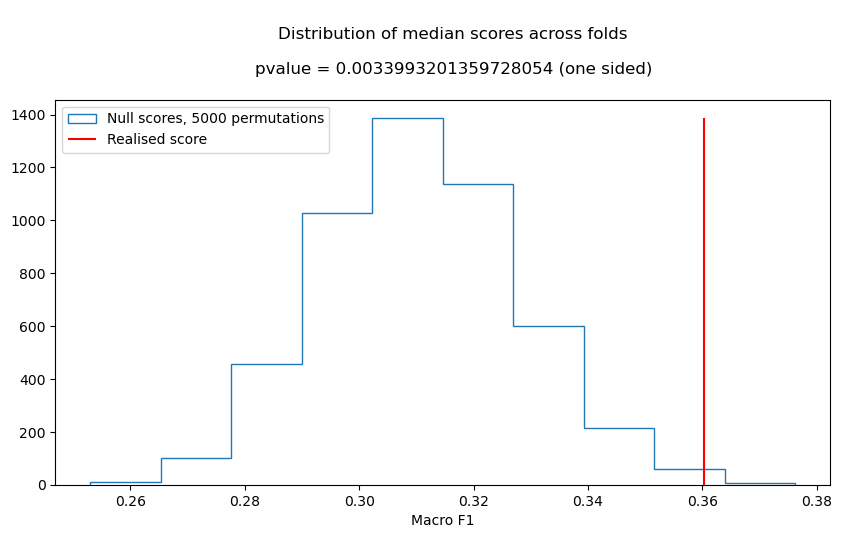

In [11]:
f, ax = plt.subplots(figsize=(10, 5))
h = ax.hist(median_scores, histtype="step", label=f"Null scores, {N} permutations")
ax.vlines(median_test, ymin=0, ymax=np.max(h[0]), color="red", label="Realised score")
ax.set_title(
    f"""
    Distribution of median scores across folds\n
    pvalue = {pvalue} (one sided)
    """
)
ax.legend(loc="upper left")
ax.set_xlabel("Macro F1")
plt.show()

# Multiple comparisons adjustement

## Perms + FDR control

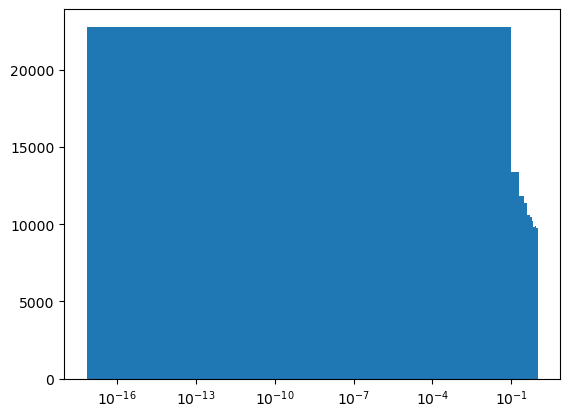

In [12]:
from nilearn.connectome import vec_to_sym_matrix
from statsmodels.stats.multitest import fdrcorrection
n_regions = int(np.sqrt(masker.topology_.sum()))

mean_perm_patterns = np.stack(permweights, axis=0).mean(axis=1)
mean_patterns = np.mean(patterns, axis=0)

pvalues_more = (np.sum(mean_patterns > mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues_less = (np.sum(mean_patterns < mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues = np.minimum(pvalues_less, pvalues_more) * 2

pvalues_corr = []
for class_idx in range(k):
    pvalues_corr.append(fdrcorrection(
        pvalues[:, class_idx]
    )[1])
pvalues_corr = np.stack(pvalues_corr, axis=1)
pvalues_corr = vec_to_sym_matrix(
        pvalues.transpose((1, 0)), diagonal=np.zeros((k, n_regions))
)
plt.hist(pvalues_corr.flatten())
plt.xscale("log")
plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from neuroginius.plotting import plot_matrix

def plot_haufe_pattern_no_cv(hmat, disp_atlas, cats):
    # TODO move as parameters or infer from data
    vmin = -90
    vmax = 90
    bounds=(vmin, vmax)
    cmap = "seismic"
    vals = []
    coeffs_var = []

    for i, cat in enumerate(cats):
        meanmap = np.mean(hmat[:, i, ...], axis=0)
        cvmap = np.std(hmat[:, i, ...], axis=0) / meanmap
        cvmap = np.where(np.isnan(cvmap), 0, cvmap)
        print(np.unique(cvmap))
        vals.append(meanmap)
        coeffs_var.append(cvmap)

    fig = plt.figure(figsize=(9, 12))

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(len(cats), 1),
                    axes_pad=0.4,
                    share_all=False,
                    label_mode="L",
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="2%",
                    cbar_pad=0.1
                    )

    for i, (val, ax) in enumerate(zip(vals,grid)):
        im = plot_matrix(
            val,
            disp_atlas,
            axes=ax,
            bounds=bounds,
            cmap="seismic",
            cbar=False
        )
        ax.set_title(cats[i])
        # Keep ticks only where we have labels
        if i <= 1:
            ax.xaxis.set_ticks_position('none') 
            
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    grid.cbar_axes[0].colorbar(ScalarMappable(norm=norm, cmap=cmap))
    
    cax = grid.cbar_axes[0]
    axis = cax.axis[cax.orientation]
    axis.label.set_text("Haufe's pattern value")

    return fig

/tmp/ipykernel_1584901/1600407175.py:19: RuntimeWarning: invalid value encountered in divide
  cvmap = np.std(hmat[:, i, ...], axis=0) / meanmap


[-0.67977719 -0.6540018  -0.64203227 ...  0.66094836  0.67992554
  0.70366251]
[-12.86026431 -11.62970063  -6.73567487 ...   9.03930399  13.16227283
  37.41711873]


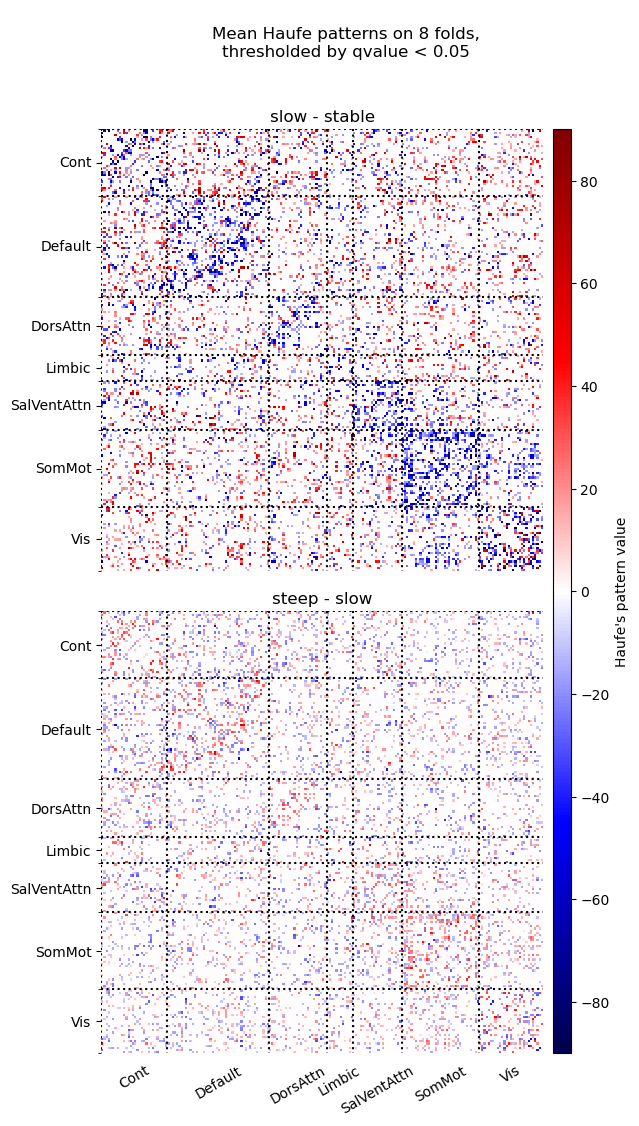

/tmp/ipykernel_1584901/1877825677.py:19: RuntimeWarning: invalid value encountered in divide
  varcoeff = np.std(thresh_map, axis=0) / np.mean(thresh_map, axis=0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


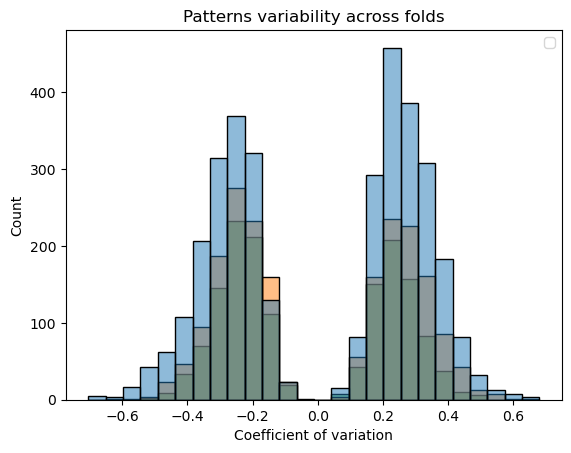

In [14]:
thresh_map = np.where(pvalues_corr < (0.05), hmat, 0)
#diffmaps = thresh_map - thresh_map[:, 0, ...].reshape((8,1,200,200))
diffmaps = np.zeros((outer_cv.n_splits, 2, *matrices.shape[1:]))
stable_patterns = thresh_map[:, 0, ...]
slow_patterns = thresh_map[:, 1, ...]
steep_patterns = thresh_map[:, 2, ...]

diffmaps[:, 0, ...] = slow_patterns - stable_patterns
diffmaps[:, 1, ...] = steep_patterns - slow_patterns

fig = plot_haufe_pattern_no_cv(diffmaps, disp_atlas, ("slow - stable", "steep - slow"))
fig.suptitle(
        f"""
        Mean Haufe patterns on {len(hmat)} folds,
        thresholded by qvalue < 0.05
        """)
plt.show()

varcoeff = np.std(thresh_map, axis=0) / np.mean(thresh_map, axis=0)
varcoeff = sym_matrix_to_vec(varcoeff, discard_diagonal=True)
df = pd.DataFrame(varcoeff.T, columns=["Stable", "Slow decline", "Steep decline"])
m = df.melt(var_name="Cognitive trajectory", value_name="Coefficient of variation")
sns.histplot(
    m, x="Coefficient of variation", hue="Cognitive trajectory"
)
plt.title("Patterns variability across folds")
plt.legend()
plt.show()


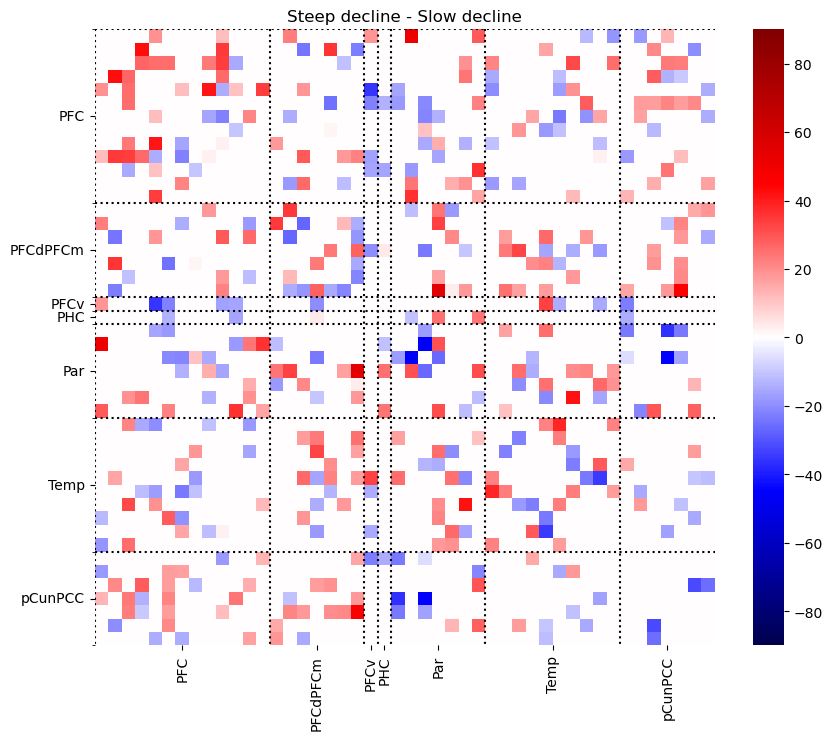

In [15]:
# Zoom on DMN
from functools import reduce

def add_one_if_dmn(a, b):
    if a == "Default":
        return 1
    elif isinstance(a, str):
        return 0
    if b == "Default":
        return a + 1
    else:
        return a
n_regions_dmn = reduce(
    add_one_if_dmn,
    atlas.macro_labels
)
diffmap = thresh_map[:, 2, ...] - thresh_map[:, 1, ...]
dmn_masker = MatrixMasker(("Default",), ("Default",))
res = dmn_masker.fit_transform(diffmap)
reprojected = vec_to_sym_matrix(res, diagonal=np.zeros((outer_cv.n_splits, n_regions_dmn)))
label_msk = np.array(atlas.macro_labels) == "Default"
regions = np.array(atlas.labels[label_msk])
regions = list(np.array(regions).astype(str))
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    if atlas.name == "schaefer200":
        macro_labels = list(map(region_split, regions))
    else:
        macro_labels = regions

f, ax = plt.subplots(figsize=(10, 8))
mock_atlas = MockAtlas()
plot_matrix(reprojected.mean(axis=0), mock_atlas, cmap="seismic", axes=ax, bounds=(-90, 90))
ax.set_xticklabels(np.unique(mock_atlas.macro_labels), rotation=90)
plt.title("Steep decline - Slow decline")
plt.show()

In [16]:
from pingouin import intraclass_corr

data = sym_matrix_to_vec(hmat, discard_diagonal=True)

In [17]:
region_idx = tuple(range(data.shape[2])) * data.shape[1]
region_idx = list(map(str, region_idx))
frames = []
for i, ratings in enumerate(data):
    frame = pd.DataFrame(ratings.T, columns=cats)
    frame["model"] = f"model_{i}"
    frame = frame.melt(id_vars="model", var_name="cognitive_trajectory")
    frame["cognitive_trajectory"] = frame["cognitive_trajectory"] + region_idx
    frames.append(frame)
    

### Compute ICC

In [18]:
import pingouin
pingouin.options['round'] = 5

In [19]:
long_rating = pd.concat(frames)
res = intraclass_corr(long_rating, targets="cognitive_trajectory", raters="model", ratings="value")
res

(    Type              Description      ICC         F    df1     df2  pval  \
 0   ICC1   Single raters absolute  0.77721  28.90872  59699  417900   0.0   
 1   ICC2     Single random raters  0.77722  28.92558  59699  417893   0.0   
 2   ICC3      Single fixed raters  0.77732  28.92558  59699  417893   0.0   
 3  ICC1k  Average raters absolute  0.96541  28.90872  59699  417900   0.0   
 4  ICC2k    Average random raters  0.96541  28.92558  59699  417893   0.0   
 5  ICC3k     Average fixed raters  0.96543  28.92558  59699  417893   0.0   
 
           CI95%  
 0  [0.78, 0.78]  
 1  [0.78, 0.78]  
 2  [0.78, 0.78]  
 3  [0.96, 0.97]  
 4  [0.96, 0.97]  
 5  [0.97, 0.97]  ,
 0.7751400255102281,
 0.7794887967390942)

### Aggregate results by network

In [22]:
# TODO Matrix group groupby, custom func
# Matrix and atlas as attributes
from neuroginius.networks import group_by_networks
from neuroginius.atlas import Atlas
from neuroginius.iterables import unique
import itertools as it

def default_agg_func(block):
    return (block.mean(),)

class MatrixResult:
    def __init__(self, matrix, atlas) -> None:
        self.atlas = atlas
        self.matrix = matrix
        self._set_sorted_matrix()
    
    def _set_sorted_matrix(self):
        """Reorganize the matrix by macro labels, store
        the sorted matrix and a mapping from networks name
        to indexes in the sorted matrix
        """

        ticks, sort_index = group_by_networks(self.atlas.macro_labels)
        matrix_sort = np.ix_(sort_index, sort_index)

        self.sorted_matrix = self.matrix[matrix_sort]
        new_labels = sorted(tuple(unique(atlas.macro_labels)))
        self.network_to_idx = pd.Series(dict(zip(
            new_labels,
            it.pairwise(ticks)
        )))

    def get_macro_matrix(self, agg_func=default_agg_func):
        """Get a matrix reorganized by networks

        Args:
            agg_func (function, optional): function to compute
            the aggregated of each cell, from the block of original
            values. Defaults to default_agg_func, which performs a simple
            mean

        Returns:
            DataFrame: summary per network of the original matrix.
        """
        gen = self._gen_macro_values(
            agg_func=agg_func
        )
        comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "connectivity"])
        pivoted = comparisons.pivot(index="node_a", columns="node_b")
        return pivoted.loc[:, "connectivity"]

    # This could be a function on its own
    def _gen_macro_values(self, agg_func):
        for network_a, network_b in it.product(self.network_to_idx.index, self.network_to_idx.index):
            loc_a, loc_b = self.network_to_idx[network_a], self.network_to_idx[network_b]
            block = self.matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]

            yield network_a, network_b, *agg_func(block)
    
    def plot(self):
        pass
        
    
        

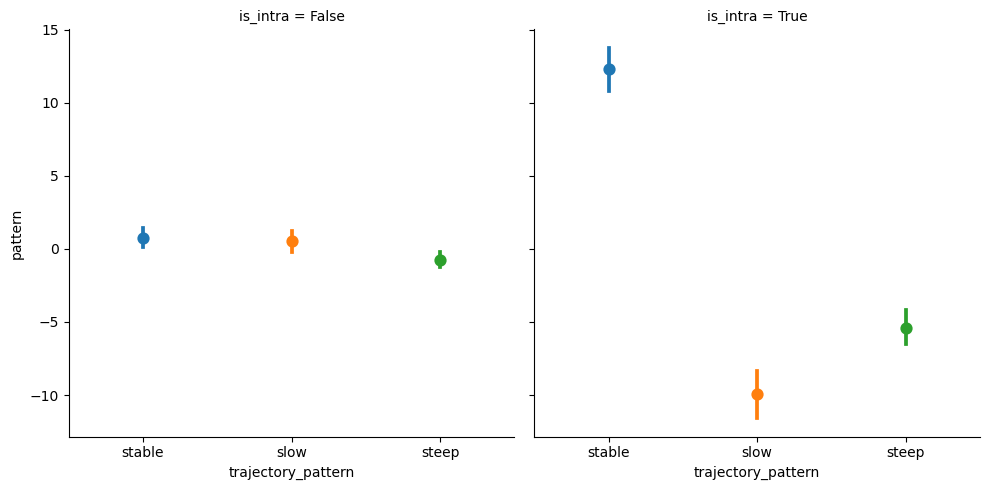

In [238]:
def all_block(block):
    return block[block != 0]

comparisons = pd.DataFrame(columns=["node_a", "node_b", "trajectory_pattern"])
for i, cat in enumerate(cats):
    netmap = thresh_map.mean(axis=0)[i, :, :]
    m = MatrixResult(netmap, atlas)
    gen = m._gen_macro_values(all_block)
    new_df = pd.DataFrame(gen).rename(columns={
        0: "node_a",
        1: "node_b",
    })
    new_df["trajectory_pattern"] = cat
    comparisons = pd.concat([comparisons, new_df])

comparisons["is_intra"] = (comparisons.node_a == comparisons.node_b)
res = comparisons.melt(
    id_vars=["node_a", "node_b", "trajectory_pattern", "is_intra"], var_name="region", value_name="pattern"
).dropna()

sns.catplot(res, x="trajectory_pattern", hue="trajectory_pattern", y="pattern", col="is_intra", kind="point")
plt.show()

In [236]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data = res[res.is_intra == True]
model = ols(
    "pattern ~ C(trajectory_pattern)", data=data
).fit()

tukey = pairwise_tukeyhsd(endog=data['pattern'],  # Dependent variable
                          groups=data['trajectory_pattern'],  # Group variable
                          alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  slow stable  22.1972    0.0  19.6397  24.7547   True
  slow  steep   4.5325 0.0022   1.3782   7.6868   True
stable  steep -17.6648    0.0 -20.5183 -14.8112   True
------------------------------------------------------


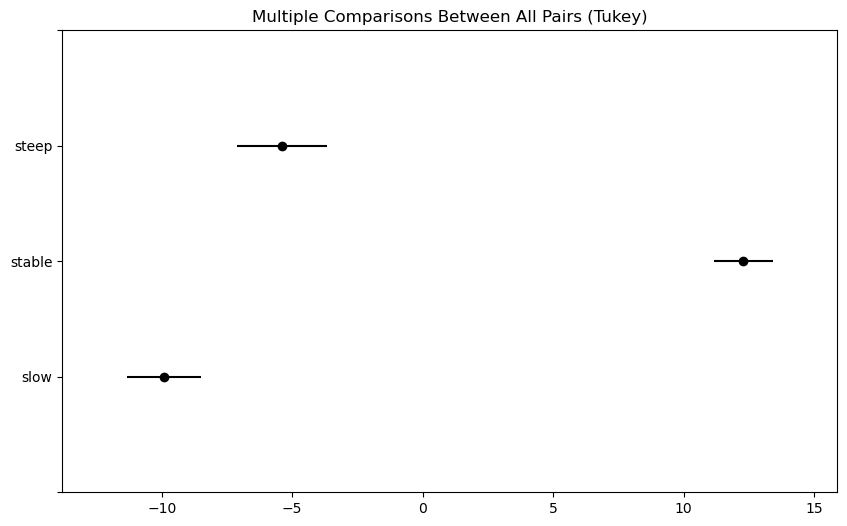

In [240]:
tukey.plot_simultaneous()
plt.show()

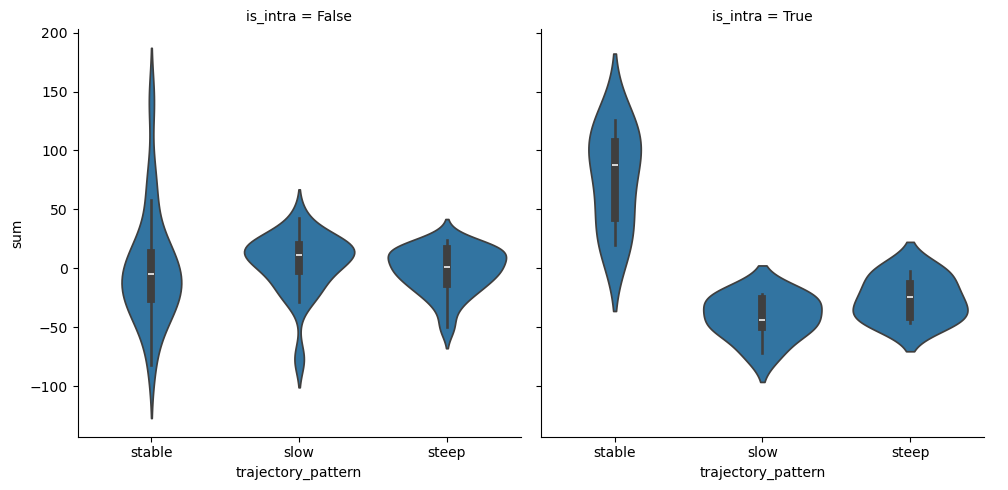

In [142]:
sns.catplot(
   comparisons, x="trajectory_pattern", y="sum", col="is_intra", kind="violin"
)
plt.show()
# TODO Haufe values instead of counts

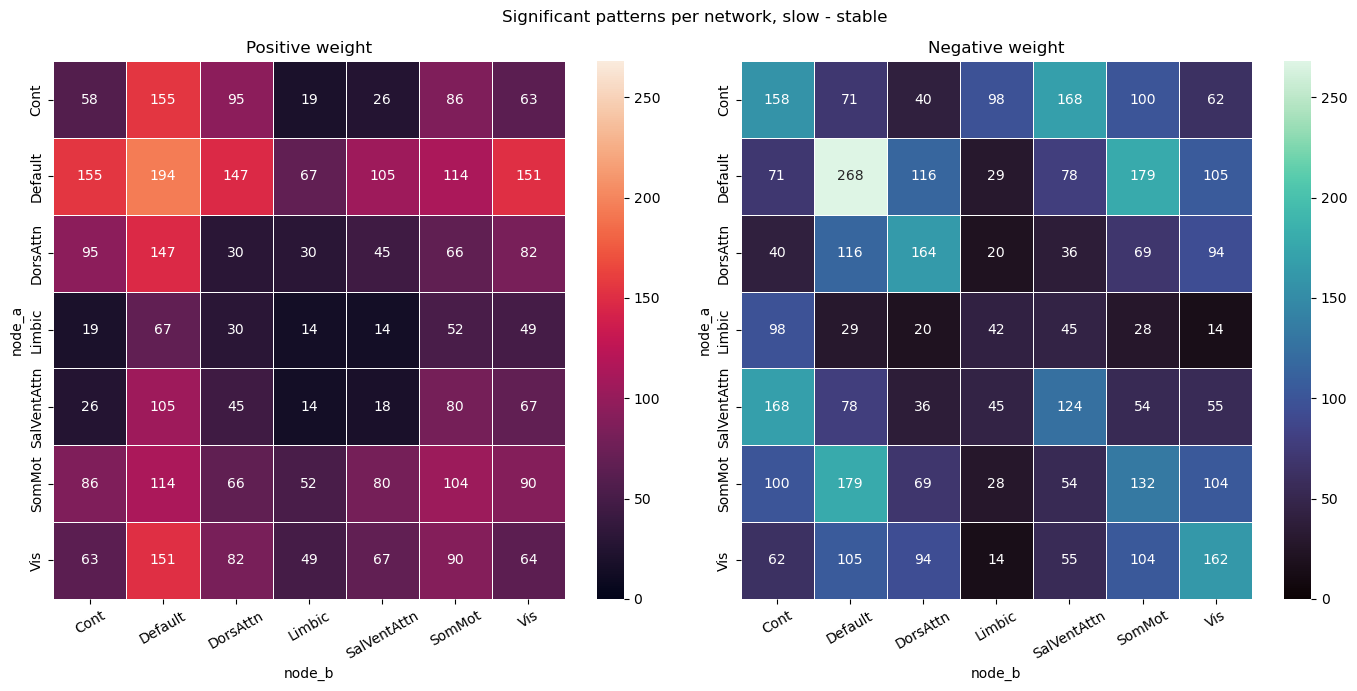

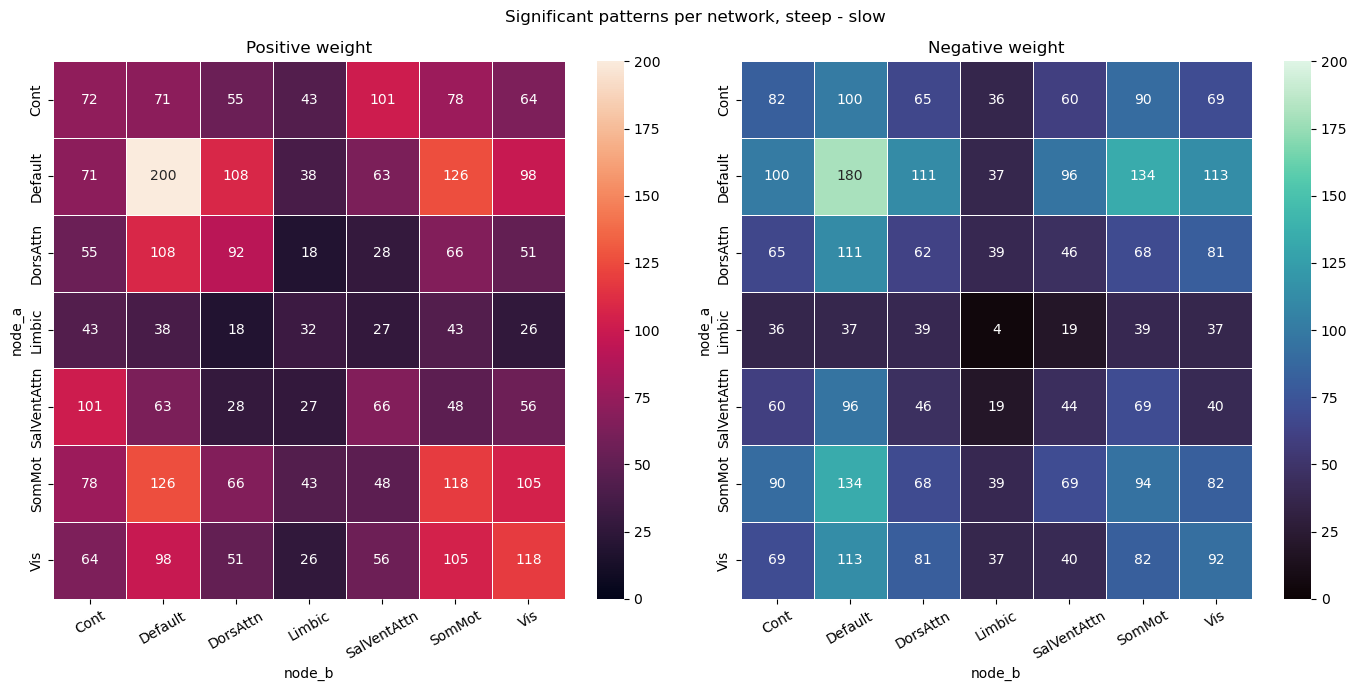

In [101]:
from neuroginius.networks import edge_counts

for i in range(2):
    tmap = thresh_map.mean(axis=0)[i + 1, :, :] - thresh_map.mean(axis=0)[i, :, :]

    m = MatrixResult(tmap, atlas)
    gen = m._gen_macro_values(agg_func=edge_counts)
    comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])
    comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

    max_count = comparisons_pv.values.max()
    heat_kwargs = {
        "vmax": max_count,
        "vmin": 0,
        "annot": True,
        "linewidth": 0.5
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0], fmt="d")
    axes[0].set_title("Positive weight")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)

    sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1], fmt="d")
    axes[1].set_title("Negative weight")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)
    fig.suptitle(f"Significant patterns per network, {cats[i+1]} - {cats[i]}")
    fig.tight_layout()
    fig.show()

    
    
# TODO Relative importance of networks